# Grid world path optimization using genetic algorithms

## Importing modules

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Video

import functions as fn

## Parameters

In [2]:
# Paths
RESULTS_PATH = "./results"
GA_RESULTS_PATH = f"{RESULTS_PATH}/GA results"
ALL_TO_ALL_RESULTS_PATH = f"{GA_RESULTS_PATH}/all to all results"
ALL_TO_ALL_VIDEO_PATH = f"{GA_RESULTS_PATH}/all_to_all_results.mp4"
ALL_TO_BEST_RESULTS_PATH = f"{GA_RESULTS_PATH}/all to best results"
ALL_TO_BEST_VIDEO_PATH = f"{GA_RESULTS_PATH}/all_to_best_results.mp4"
HYBRID_RESULTS_PATH = f"{GA_RESULTS_PATH}/hybrid results"
HYBRID_VIDEO_PATH = f"{GA_RESULTS_PATH}/hybrid_results.mp4"

# Grid parameters
GRID_SIZE = (10, 15)
START_POSITION = (6, 1)
END_POSITION = (4, 13)
OBSTACLES = [
    (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14),
    (1, 0), (1, 14), (2, 0), (2, 5), (2, 6), (2, 11), (2, 14), (3, 0), (3, 11), (3, 14), (4, 0), (4, 9), (4, 10), (4, 11), (4, 14), 
    (5, 0), (5, 6), (5, 11), (5, 14), (6, 0), (6, 6), (6, 9), (6, 11), (6, 14), (7, 0), (7, 6), (7, 14), (8, 0), (8, 3), (8, 6), (8, 14), 
    (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14)
]
TRAPS = [(1, 3), (2, 3), (2, 7), (3, 3), (3, 10), (4, 3), (5, 3), (5, 13), (7, 9)]
NUM_OPTIMAL_STEPS = 20

# Simulation parameters
CHROMOSOME_LENGTH = 64
POPULATION_SIZE = 1000
NUM_GENERATIONS = 1000
PENALTY_COEFFICIENTS = [1, 1.25, 1.5]
BIAS = 2
PROGRESSIVE_MUTATION = False
MUTATION_RATE = 0.01
EARLY_STOP = False
BEST_ONES_PERCENTAGE = 0.2
WORST_ONES_PERCENTAGE = 0.2

# Visualization
WINDOW_SIZE = 10

# Other
RANDOM_STATE = 42
LINE = 100*'-'
DOUBLE_LINE = 100*'='
SIMULATION_STARTED = 36*'-' + " !!! SIMULATION STARTED !!! " + 36*'-'
SIMULATION_FINISHED = 36*'-' + " !!! SIMULATION FINISHED !!! " + 35*'-'

## Results directories creation

In [3]:
os.makedirs(RESULTS_PATH, exist_ok=True)
for directory in [GA_RESULTS_PATH, ALL_TO_ALL_RESULTS_PATH, ALL_TO_BEST_RESULTS_PATH, HYBRID_RESULTS_PATH]:
    fn.create_or_empty_directory(directory)

## Grid world initialization

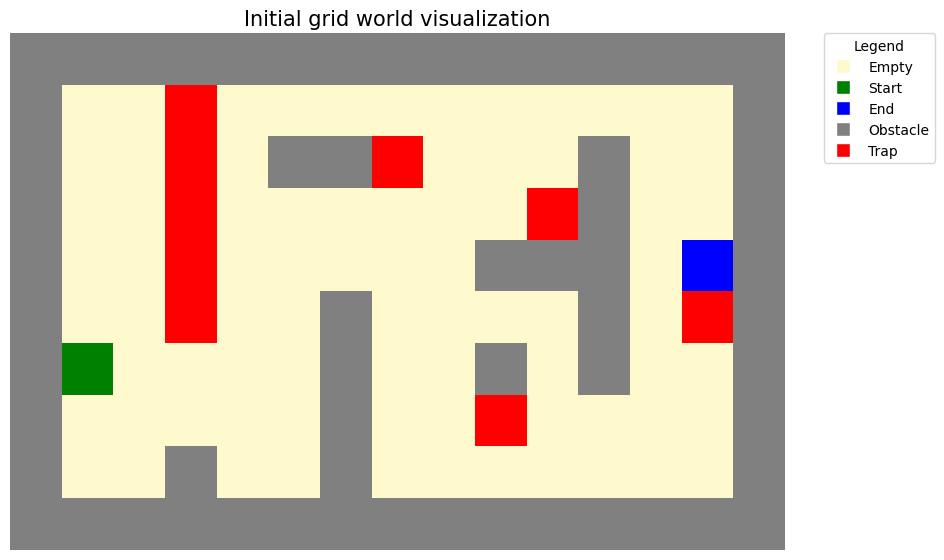

In [4]:
initial_grid_world = fn.grid_world_creation(GRID_SIZE, START_POSITION, END_POSITION, OBSTACLES, TRAPS)
fn.grid_world_visualization(initial_grid_world,title="Initial grid world visualization", agent_flag=0)

## All to all crossover case

In this simulation, we explore the principles of genetic algorithms with a focus on the role of bias in the selection process. Genetic algorithms, inspired by natural selection, use mechanisms such as selection, crossover, and mutation to evolve solutions over generations. By introducing bias in the selection of parents, we aim to emphasize the importance of fitter individuals in guiding the evolution process. This bias ensures that better-performing agents have a higher chance of passing on their traits, leading to a more efficient optimization of paths and behaviors in the grid world.

### Simulation

In [5]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_paths = []
best_generation = NUM_GENERATIONS
first_full_path_generation = 0
mutation_rate = 0
converge_flag = False

for generation in range(1, NUM_GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(CHROMOSOME_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []
        for i in range(int(POPULATION_SIZE/2)):
            agent1 = fn.selection(population_sorted, bias=BIAS, mode="rank-based", random_seed=i)
            parent_flag = False
            counter = 1
            while not parent_flag:
                agent2 = fn.selection(population_sorted, bias=BIAS, mode="rank-based", random_seed=i*42+counter)
                if agent1 != agent2:
                    parent_flag = True
                else: 
                    counter += 1

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            if PROGRESSIVE_MUTATION and mutation_rate < 0.1 and fn.check_last_n_generations_same(best_scores, secondary_scores_of_best):
                mutation_rate += MUTATION_RATE
            else:
                mutation_rate = MUTATION_RATE

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=mutation_rate, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=mutation_rate, random_seed=i**2)

            population.extend([mutated_new_agent1, mutated_new_agent2])

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_paths = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, path = fn.fitness_score_calculation(
            agent_path=agent, 
            grid_world=initial_grid_world, 
            chromosome_length=CHROMOSOME_LENGTH, 
            start_position=START_POSITION, 
            end_position=END_POSITION, 
            penalty_coefficients=PENALTY_COEFFICIENTS, 
            grid_size=GRID_SIZE
        )
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_score)
        grid_worlds.append(grid_world)
        population_paths.append(path)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_path = population_paths[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_paths.append(best_agent_path)
    best_grid_worlds.append(best_grid_world)

    if generation == 1 or generation % 10 == 0:
        print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
        print(LINE)

    if best_score == 0:
        if not first_full_path_generation:
            first_full_path_generation = generation
    
        if EARLY_STOP or secondary_score_of_best == NUM_OPTIMAL_STEPS:
            converge_flag = True
            best_generation = generation
            print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
            print(LINE)
            break

_, best_indices_sorted = fn.population_sorting(best_population_paths, best_scores, secondary_scores_of_best)
best_generation = best_indices_sorted[0] + 1
final_best_score = best_scores[best_indices_sorted[0]]
final_best_secondary_score = secondary_scores_of_best[best_indices_sorted[0]]

if not converge_flag:
    print("Optimal path is not found!")

print(f"The best generation: {best_generation}")
print(f"The best primary score: {final_best_score}")
print(f"The best secondary score: {final_best_secondary_score}")
print(f"The first full path generation: {first_full_path_generation}")

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. generation finished - best score: 8.8388 - median score: 16.298 - mean score: 15.7787 - steps: 14
----------------------------------------------------------------------------------------------------
 10. generation finished - best score: 5.0 - median score: 15.0 - mean score: 13.6965 - steps: 14
----------------------------------------------------------------------------------------------------
 20. generation finished - best score: 2.7951 - median score: 9.5197 - mean score: 10.7858 - steps: 13
----------------------------------------------------------------------------------------------------
 30. generation finished - best score: 2.7951 - median score: 8.8388 - mean score: 9.4513 - steps: 13
----------------------------------------------------------------------------------------------------
 40. generation finished - best score: 1.5 - median score: 8.8388 - mean score: 8.8051 - s

### Result scores visualization

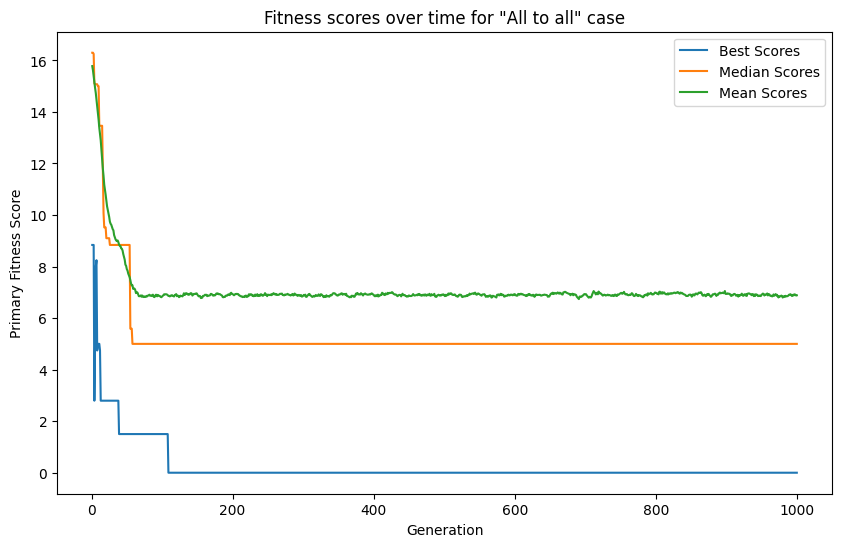

In [6]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for \"All to all\" case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

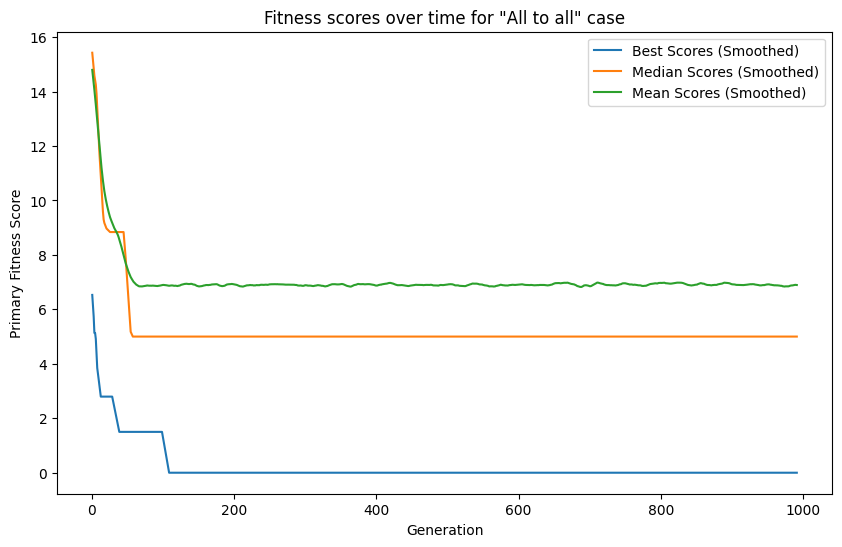

In [7]:
best_scores_smooth = fn.moving_average(best_scores, WINDOW_SIZE)
median_scores_smooth = fn.moving_average(median_scores, WINDOW_SIZE)
mean_scores_smooth = fn.moving_average(mean_scores, WINDOW_SIZE)

x_values_smooth = range(1, len(best_scores_smooth) + 1)

plt.figure(figsize=(10, 6))

plt.plot(x_values_smooth, best_scores_smooth, label="Best Scores (Smoothed)")
plt.plot(x_values_smooth, median_scores_smooth, label="Median Scores (Smoothed)")
plt.plot(x_values_smooth, mean_scores_smooth, label="Mean Scores (Smoothed)")

plt.title("Fitness scores over time for \"All to all\" case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

### Grid world path optimization evolution

1. generation 1 grid world


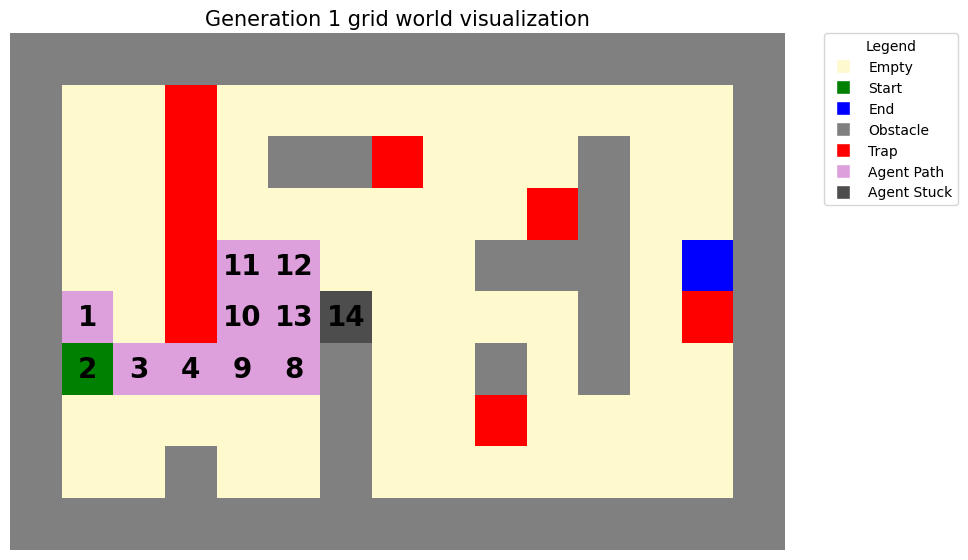

----------------------------------------------------------------------------------------------------

2. generation 100 grid world


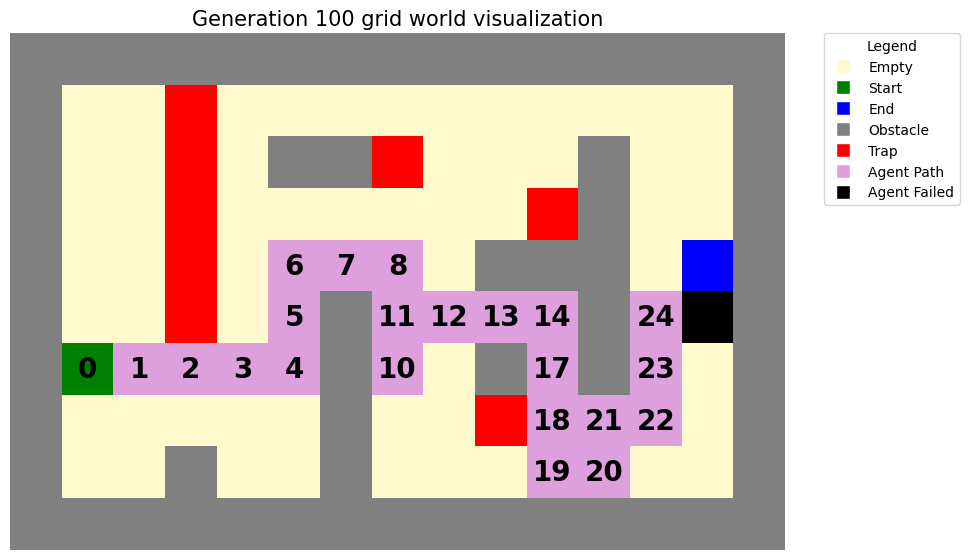

----------------------------------------------------------------------------------------------------

3. generation 109 grid world


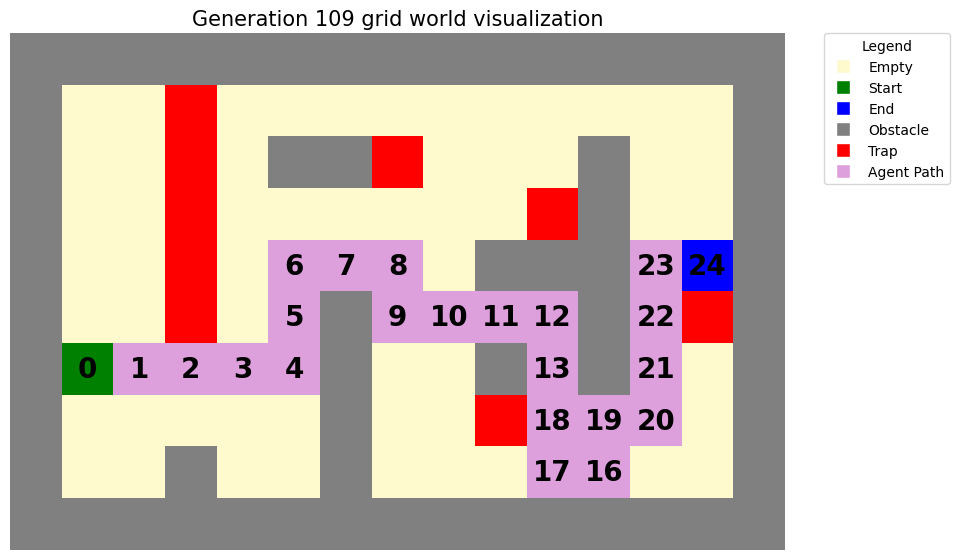

----------------------------------------------------------------------------------------------------

4. generation 200 grid world


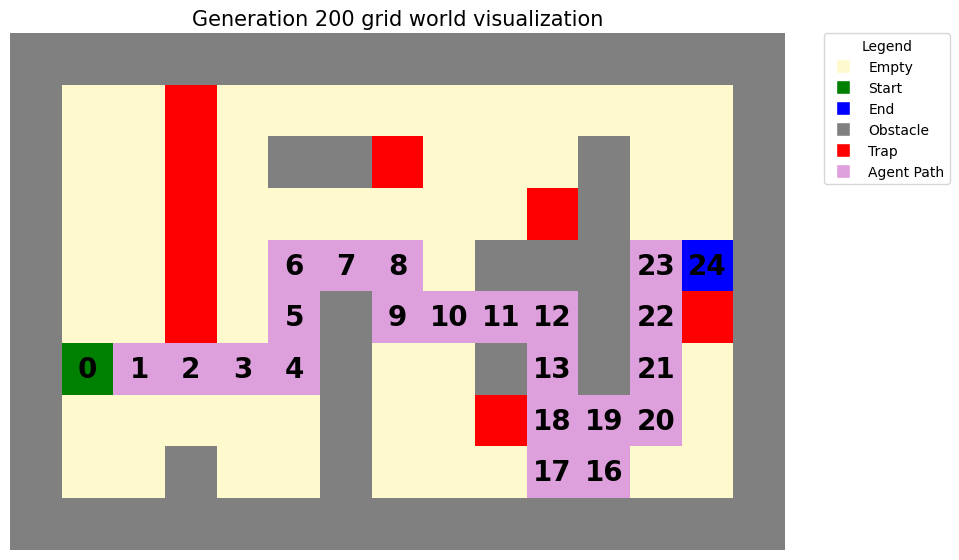

----------------------------------------------------------------------------------------------------

5. generation 300 grid world


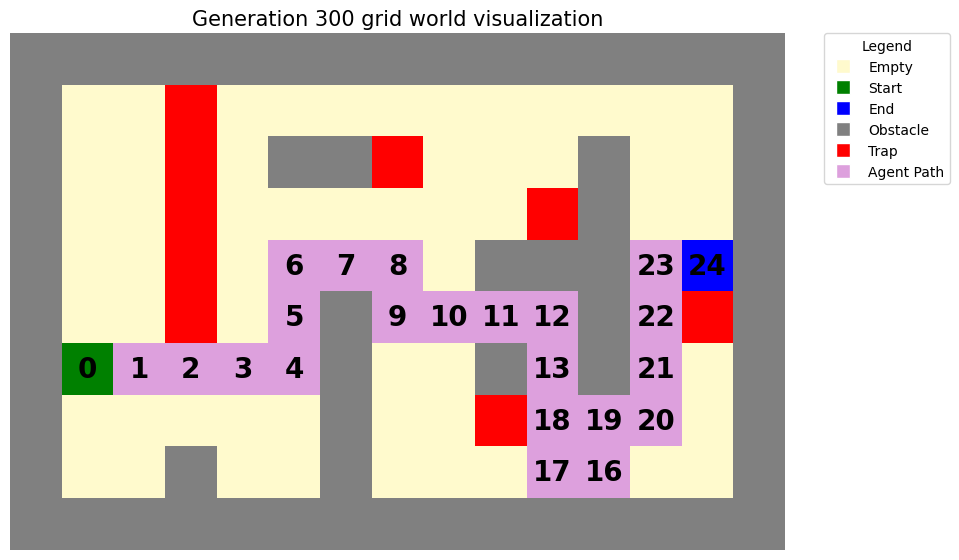

----------------------------------------------------------------------------------------------------

6. generation 400 grid world


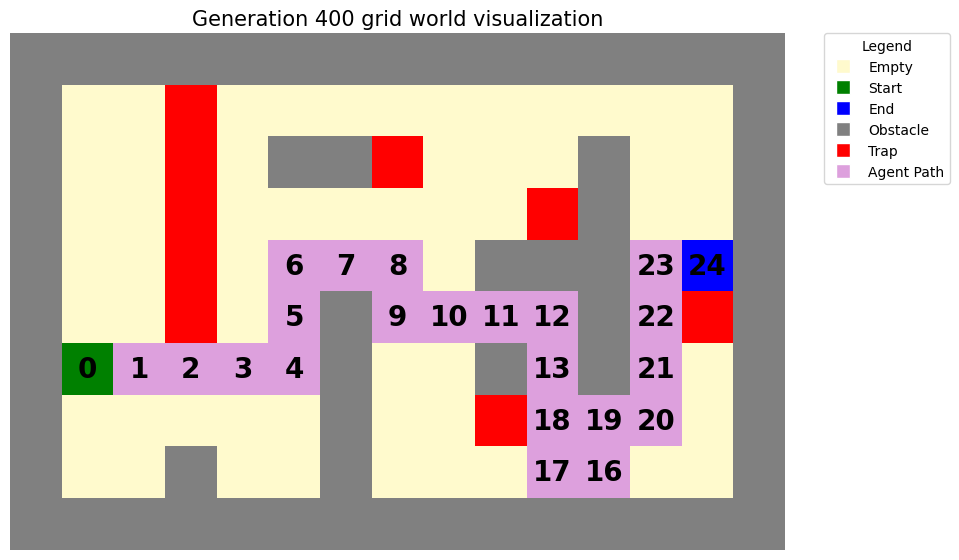

----------------------------------------------------------------------------------------------------

7. generation 500 grid world


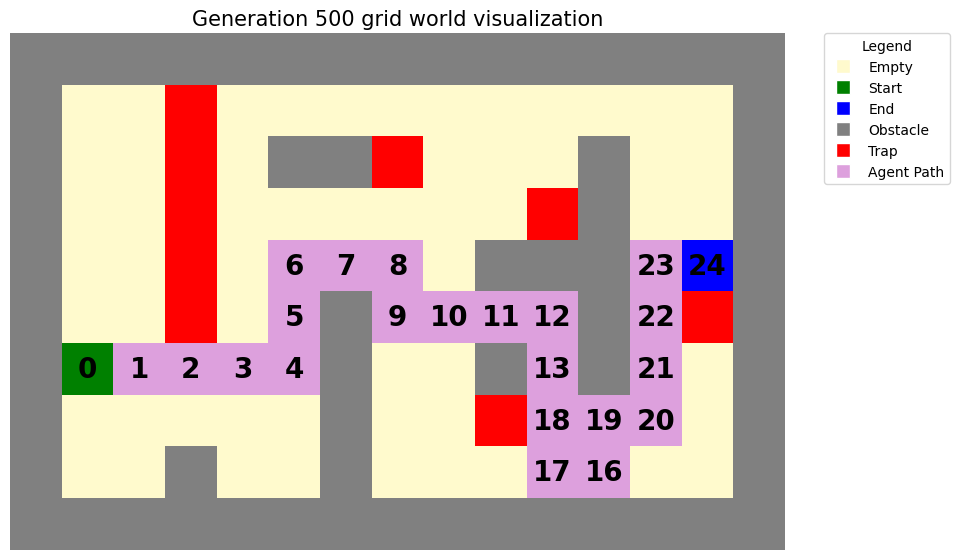

----------------------------------------------------------------------------------------------------

8. generation 600 grid world


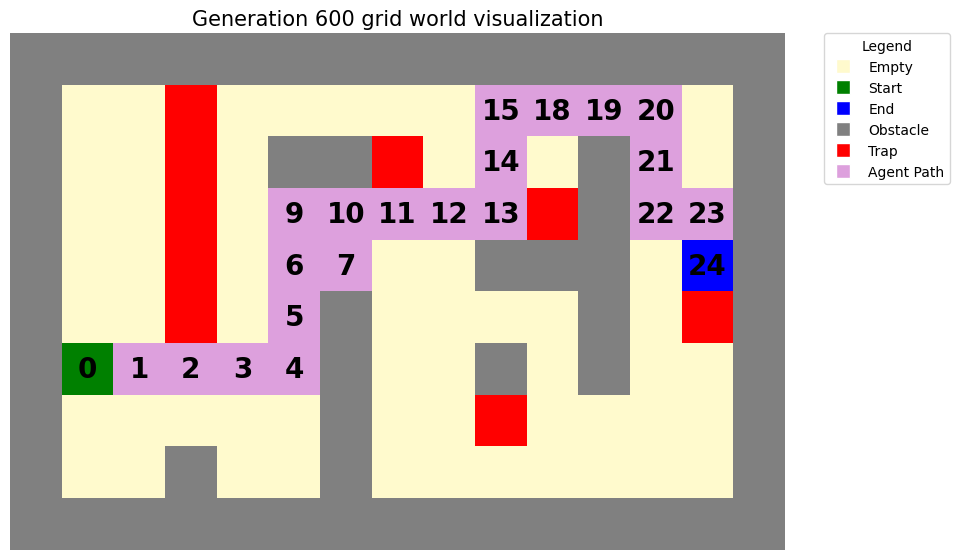

----------------------------------------------------------------------------------------------------

9. generation 700 grid world


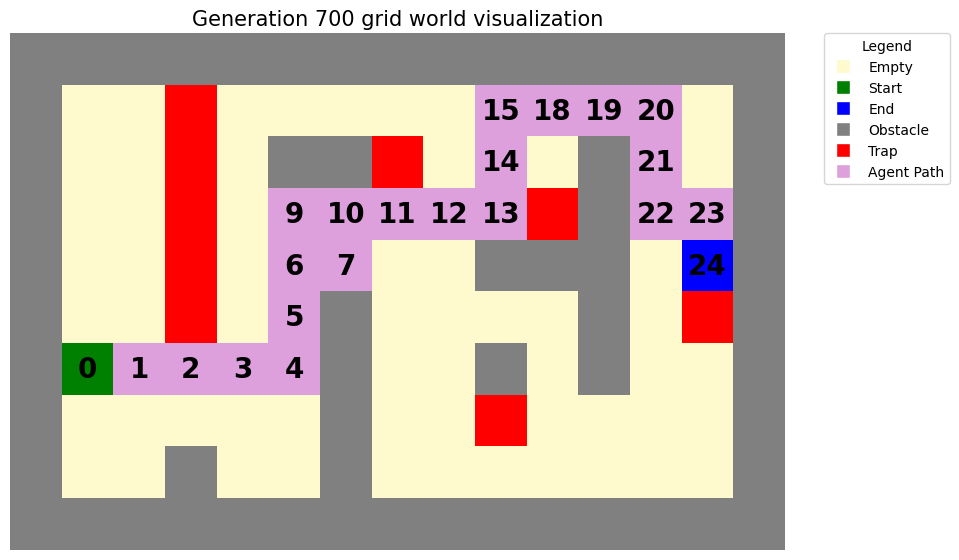

----------------------------------------------------------------------------------------------------

10. generation 800 grid world


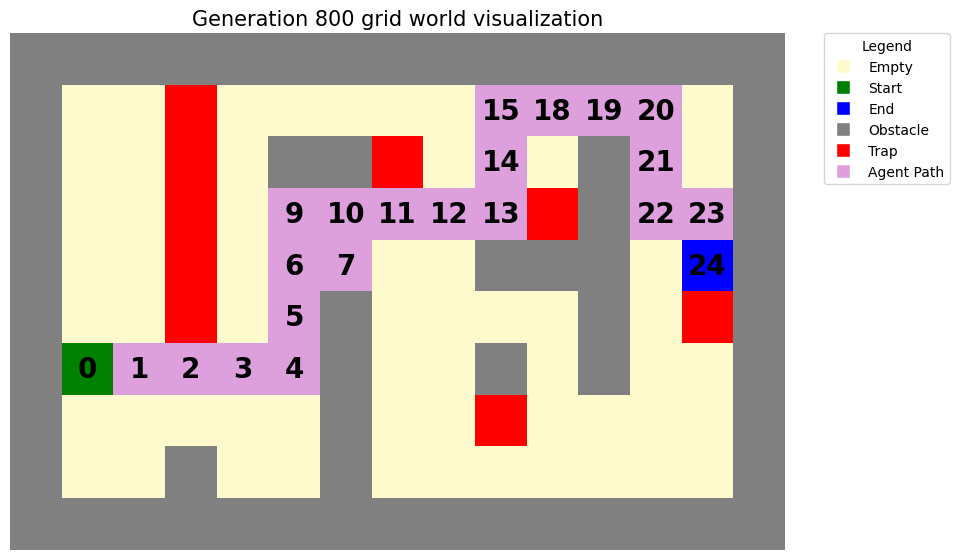

----------------------------------------------------------------------------------------------------

11. generation 900 grid world


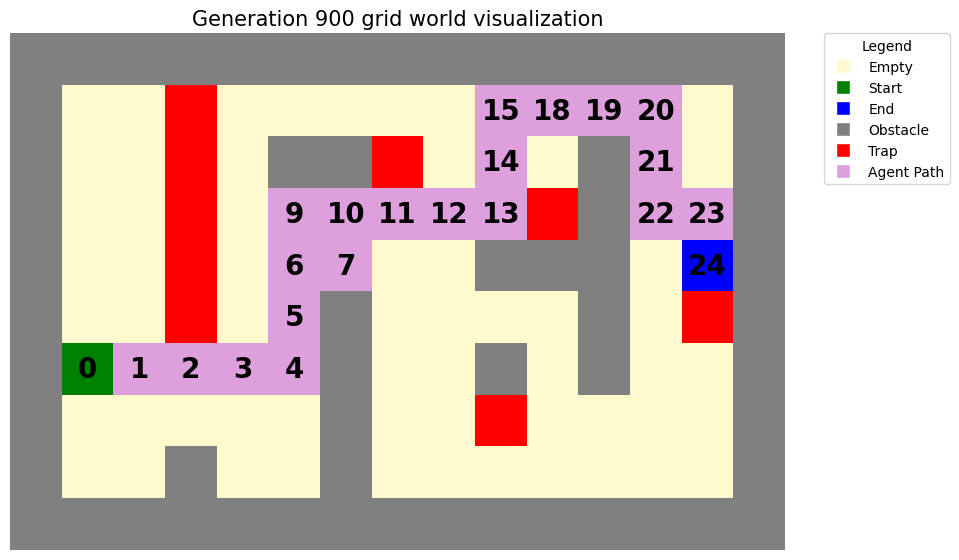

----------------------------------------------------------------------------------------------------

12. generation 1000 grid world


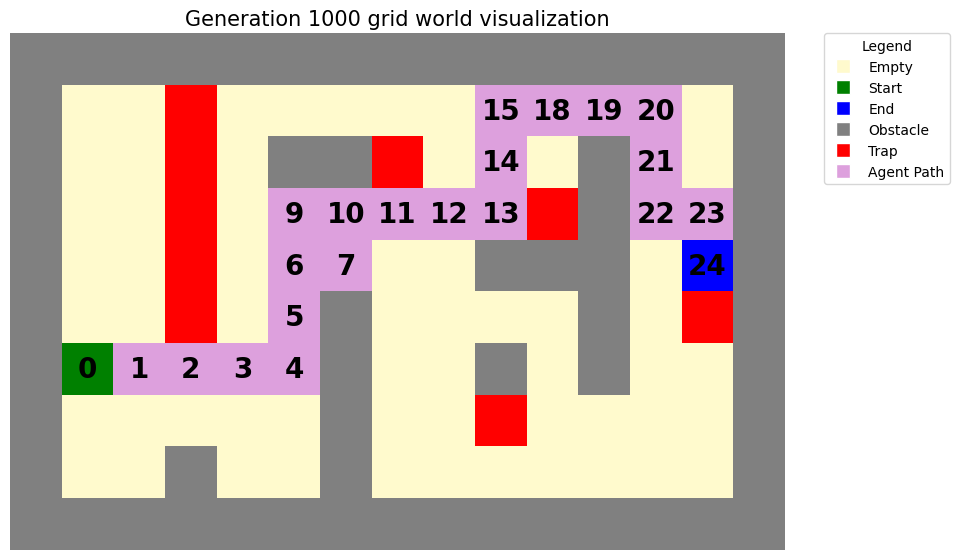

----------------------------------------------------------------------------------------------------



In [8]:
generation_step = generation // 10

counter = 1
for generation, grid_world in enumerate(best_grid_worlds, 1):
    if generation == 1 or generation == best_generation or generation%generation_step == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, agent_path=best_population_paths[generation-1], title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [9]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruction:")
fn.path_reconstruction(
    best_population_paths=best_population_paths, 
    initial_grid_world=initial_grid_world, 
    results_path=ALL_TO_ALL_RESULTS_PATH, 
    start_position=START_POSITION, 
    end_position=END_POSITION, 
    step=generation_step, 
    title_type="generation", 
    path_flag=1
)
print(LINE)
print("Video creation...")
fn.video_creation(ALL_TO_ALL_RESULTS_PATH, ALL_TO_ALL_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

PATHS RECONSTRUCTION AND VIDEO CREATION
Path reconstruction:


Processing generations/iterations: 100%|██████████| 11/11 [02:13<00:00, 12.17s/it]


----------------------------------------------------------------------------------------------------
Video creation...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


Video saved to ./results/GA results/all_to_all_results.mp4
Video creation finished!


frame=  266 fps=108 q=-1.0 Lsize=     381kB time=00:00:52.60 bitrate=  59.3kbits/s speed=21.3x    
video:377kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.938136%
[libx264 @ 0x56403f6b2180] frame I:2     Avg QP: 8.25  size: 22950
[libx264 @ 0x56403f6b2180] frame P:169   Avg QP:15.26  size:  1746
[libx264 @ 0x56403f6b2180] frame B:95    Avg QP:13.69  size:   473
[libx264 @ 0x56403f6b2180] consecutive B-frames: 35.0% 46.6% 16.9%  1.5%
[libx264 @ 0x56403f6b2180] mb I  I16..4: 81.3%  5.6% 13.1%
[libx264 @ 0x56403f6b2180] mb P  I16..4:  1.1%  0.5%  0.7%  P16..4:  1.4%  0.2%  0.1%  0.0%  0.0%    skip:96.0%
[libx264 @ 0x56403f6b2180] mb B  I16..4:  0.8%  0.3%  0.2%  B16..8:  2.0%  0.2%  0.0%  direct: 0.3%  skip:96.2%  L0:49.1% L1:49.9% BI: 1.0%
[libx264 @ 0x56403f6b2180] 8x8 transform intra:17.8% inter:56.1%
[libx264 @ 0x56403f6b2180] coded y,uvDC,uvAC intra: 13.6% 32.7% 26.8% inter: 0.4% 0.8% 0.5%
[libx264 @ 0x56403f6b2180] i16 v,h,dc,p: 66% 32%  2%  0%
[li

In [10]:
Video(ALL_TO_ALL_VIDEO_PATH, embed=True)

## All to the best ones crossover case

This case delves into the application of the Pareto Principle, or the 80/20 rule, within our genetic algorithm. By segmenting the population into the top 20% best-performing individuals and the remaining 80%, we leverage the principle that a small percentage of individuals can contribute significantly to the overall improvement of the population. The top 20% are prioritized for reproduction, ensuring that their superior traits are propagated, while the rest provide the necessary genetic diversity. This approach balances exploitation and exploration, driving the population towards optimal solutions without stagnation.

### Simulation

In [11]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

num_best = int(POPULATION_SIZE * BEST_ONES_PERCENTAGE)
num_rest = POPULATION_SIZE - num_best

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_paths = []
best_generation = NUM_GENERATIONS
first_full_path_generation = 0
mutation_rate = 0
converge_flag = False

for generation in range(1, NUM_GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(CHROMOSOME_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []

        best_individuals = population_sorted[:num_best]
        rest_individuals = population_sorted[num_best:]
        for i in range(int(POPULATION_SIZE/2)):
            agent1 = fn.selection(best_individuals, mode="uniform", random_seed=i)
            agent2 = fn.selection(rest_individuals, mode="uniform", random_seed=i*42+42)

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            if PROGRESSIVE_MUTATION and mutation_rate < 0.1 and fn.check_last_n_generations_same(best_scores, secondary_scores_of_best):
                mutation_rate += MUTATION_RATE
            else:
                mutation_rate = MUTATION_RATE

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=mutation_rate, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=mutation_rate, random_seed=i**2)

            population.extend([mutated_new_agent1, mutated_new_agent2])

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_paths = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, path = fn.fitness_score_calculation(
            agent_path=agent, 
            grid_world=initial_grid_world, 
            chromosome_length=CHROMOSOME_LENGTH, 
            start_position=START_POSITION, 
            end_position=END_POSITION, 
            penalty_coefficients=PENALTY_COEFFICIENTS, 
            grid_size=GRID_SIZE
        )
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_score)
        grid_worlds.append(grid_world)
        population_paths.append(path)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_path = population_paths[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_paths.append(best_agent_path)
    best_grid_worlds.append(best_grid_world)

    if generation == 1 or generation % 10 == 0:
        print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
        print(LINE)

    if best_score == 0:
        if not first_full_path_generation:
            first_full_path_generation = generation
    
        if EARLY_STOP or secondary_score_of_best == NUM_OPTIMAL_STEPS:
            converge_flag = True
            best_generation = generation
            print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
            print(LINE)
            break

_, best_indices_sorted = fn.population_sorting(best_population_paths, best_scores, secondary_scores_of_best)
best_generation = best_indices_sorted[0] + 1
final_best_score = best_scores[best_indices_sorted[0]]
final_best_secondary_score = secondary_scores_of_best[best_indices_sorted[0]]

if not converge_flag:
    print("Optimal path is not found!")

print(f"The best generation: {best_generation}")
print(f"The best primary score: {final_best_score}")
print(f"The best secondary score: {final_best_secondary_score}")
print(f"The first full path generation: {first_full_path_generation}")

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. generation finished - best score: 8.8388 - median score: 16.298 - mean score: 15.7787 - steps: 14
----------------------------------------------------------------------------------------------------
 10. generation finished - best score: 4.7434 - median score: 9.1001 - mean score: 10.5484 - steps: 14
----------------------------------------------------------------------------------------------------
 20. generation finished - best score: 2.7951 - median score: 5.077 - mean score: 7.4291 - steps: 15
----------------------------------------------------------------------------------------------------
 30. generation finished - best score: 2.7951 - median score: 3.75 - mean score: 5.9109 - steps: 13
----------------------------------------------------------------------------------------------------
 40. generation finished - best score: 0.0 - median score: 2.7951 - mean score: 5.7602 - 

### Result scores visualization

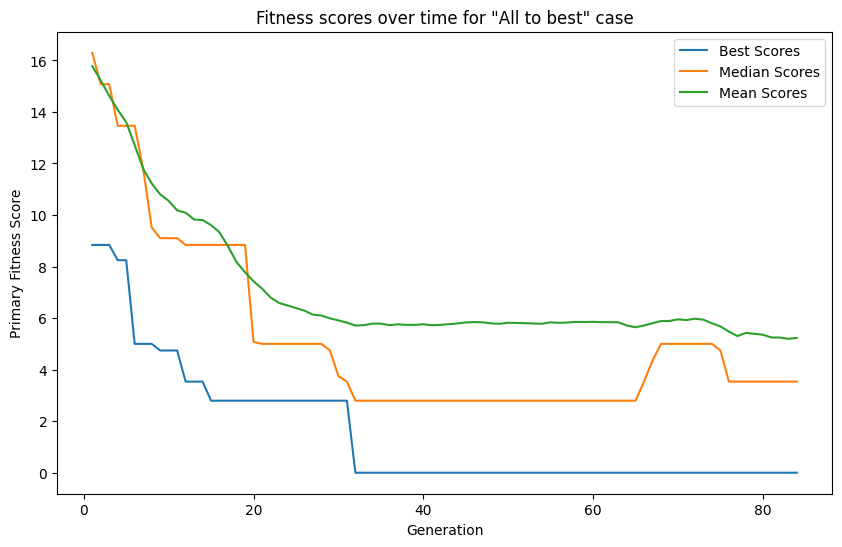

In [12]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for \"All to best\" case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

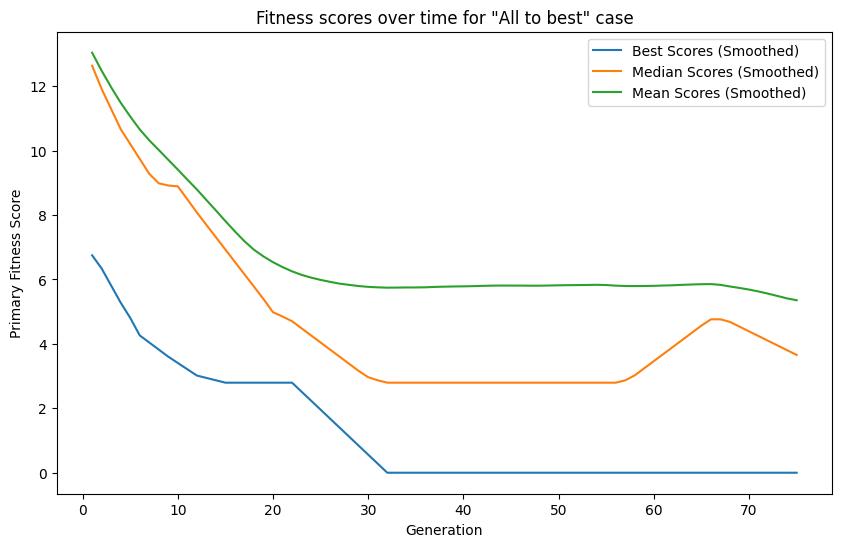

In [13]:
best_scores_smooth = fn.moving_average(best_scores, WINDOW_SIZE)
median_scores_smooth = fn.moving_average(median_scores, WINDOW_SIZE)
mean_scores_smooth = fn.moving_average(mean_scores, WINDOW_SIZE)

x_values_smooth = range(1, len(best_scores_smooth) + 1)

plt.figure(figsize=(10, 6))

plt.plot(x_values_smooth, best_scores_smooth, label="Best Scores (Smoothed)")
plt.plot(x_values_smooth, median_scores_smooth, label="Median Scores (Smoothed)")
plt.plot(x_values_smooth, mean_scores_smooth, label="Mean Scores (Smoothed)")

plt.title("Fitness scores over time for \"All to best\" case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

### Grid world path optimization evolution

1. generation 1 grid world


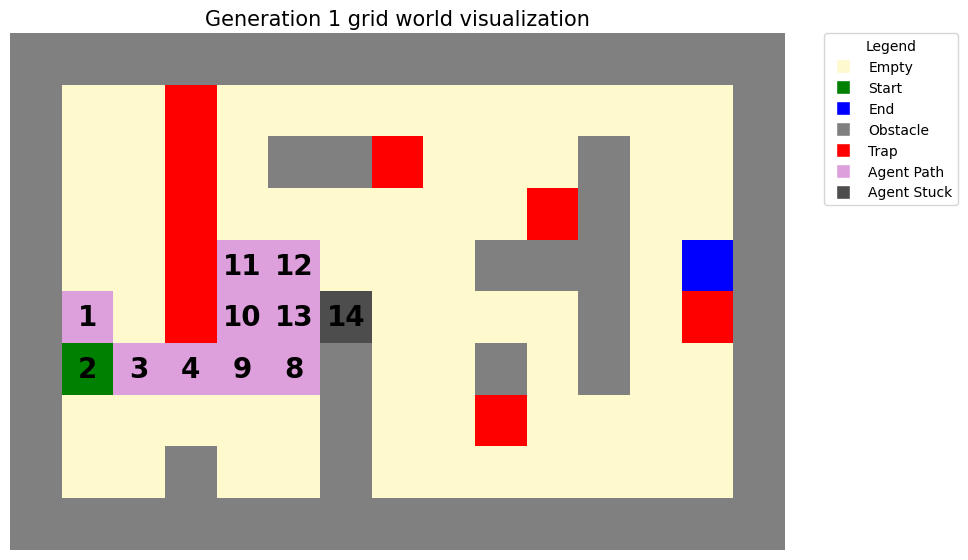

----------------------------------------------------------------------------------------------------

2. generation 8 grid world


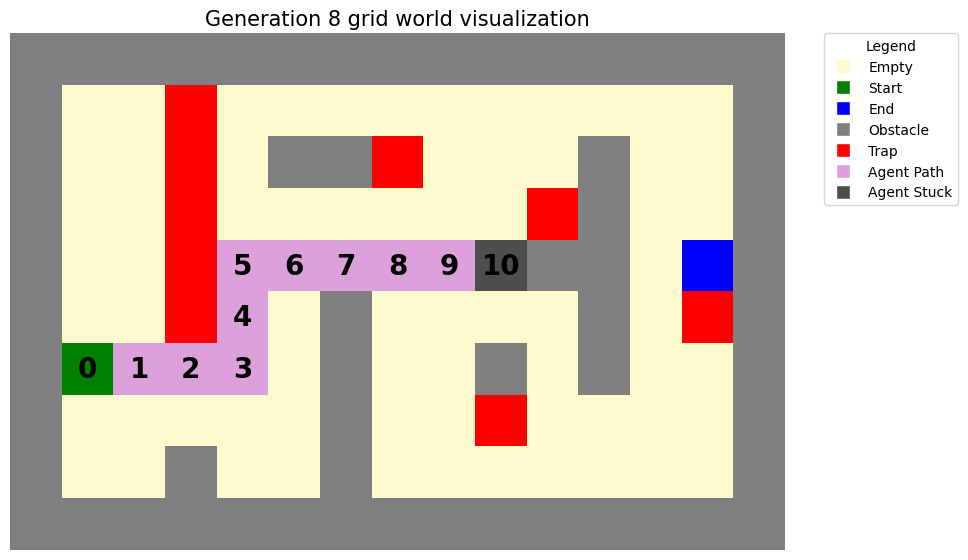

----------------------------------------------------------------------------------------------------

3. generation 16 grid world


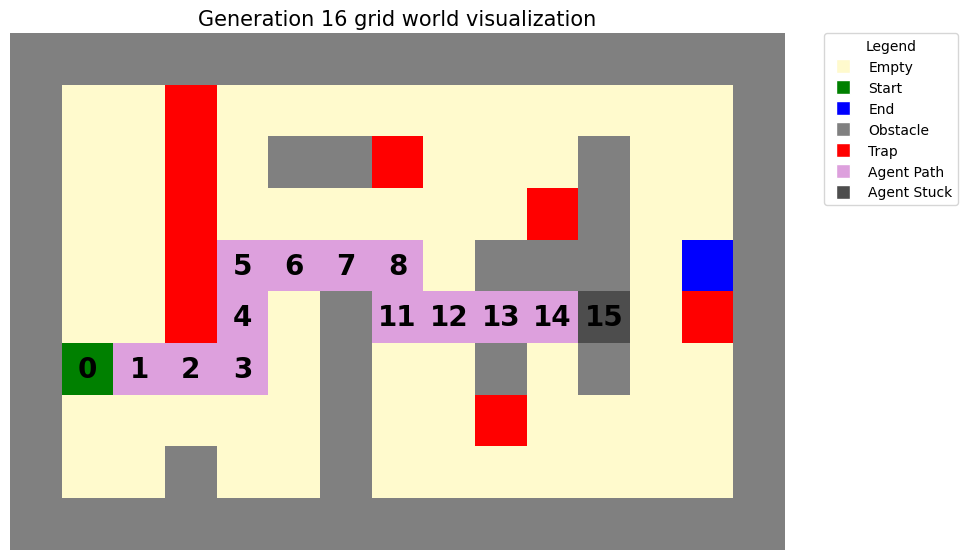

----------------------------------------------------------------------------------------------------

4. generation 24 grid world


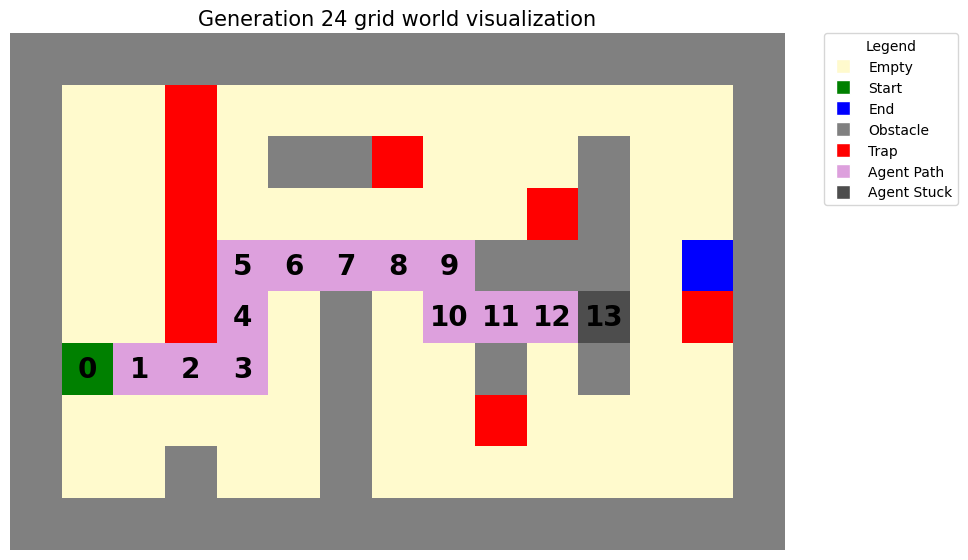

----------------------------------------------------------------------------------------------------

5. generation 32 grid world


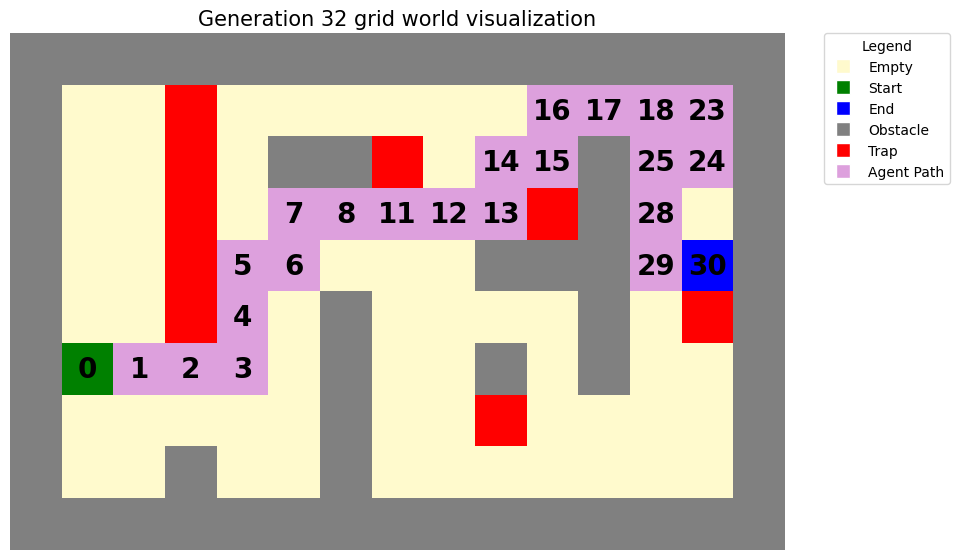

----------------------------------------------------------------------------------------------------

6. generation 40 grid world


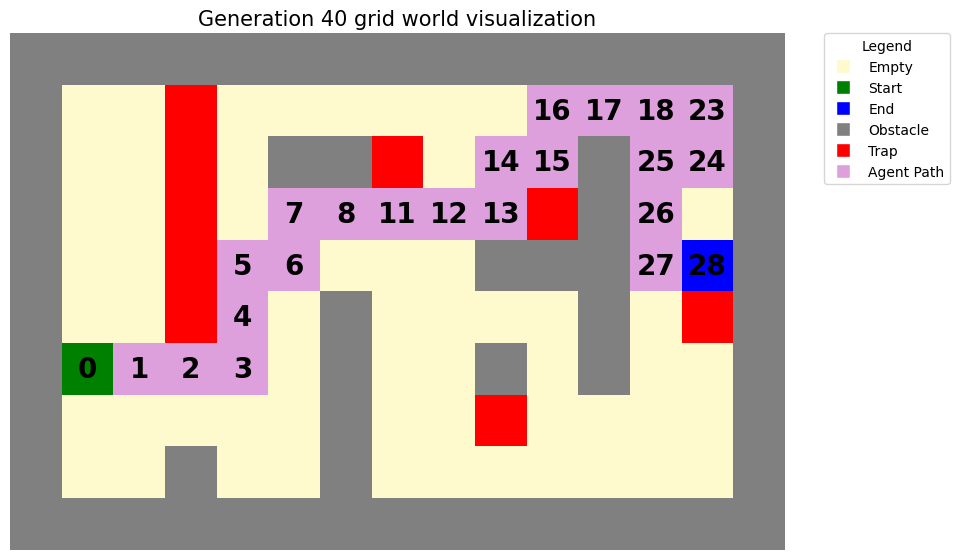

----------------------------------------------------------------------------------------------------

7. generation 48 grid world


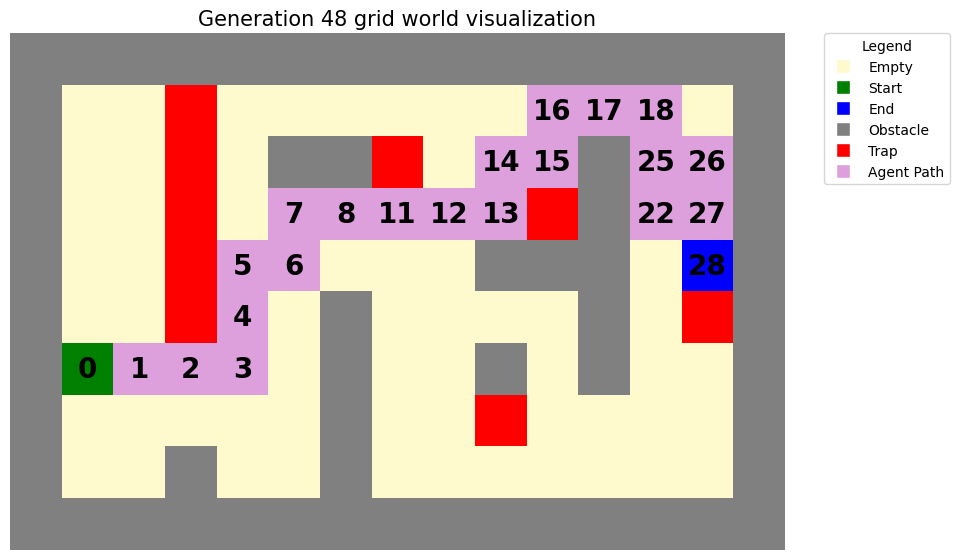

----------------------------------------------------------------------------------------------------

8. generation 56 grid world


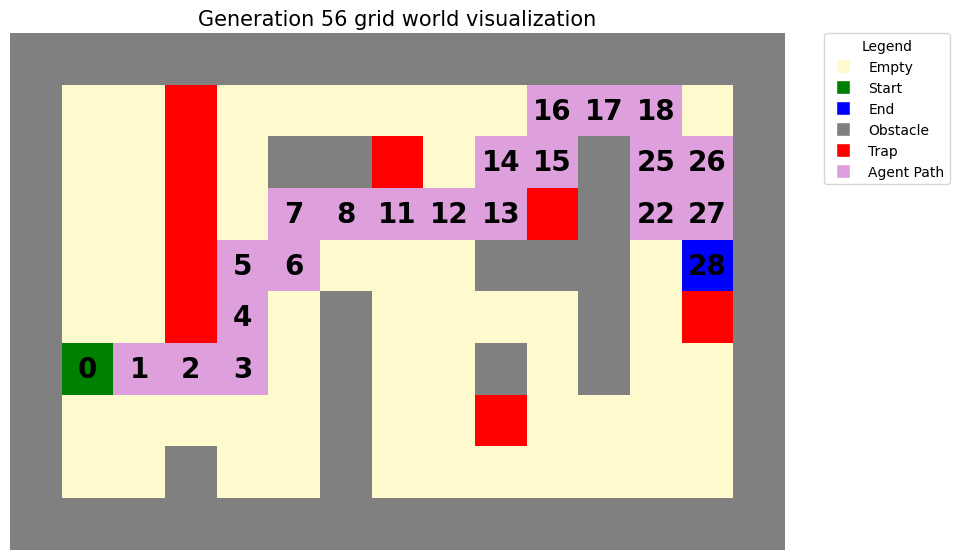

----------------------------------------------------------------------------------------------------

9. generation 64 grid world


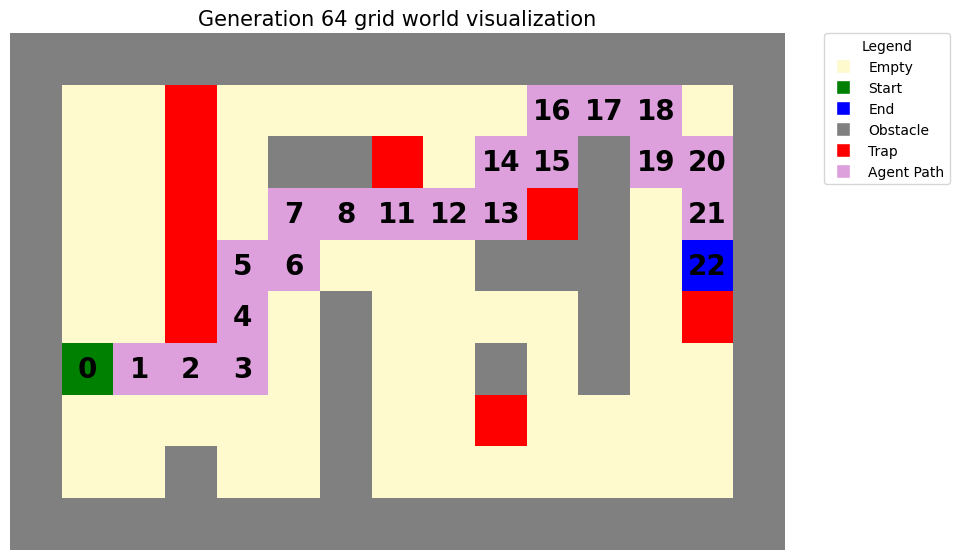

----------------------------------------------------------------------------------------------------

10. generation 72 grid world


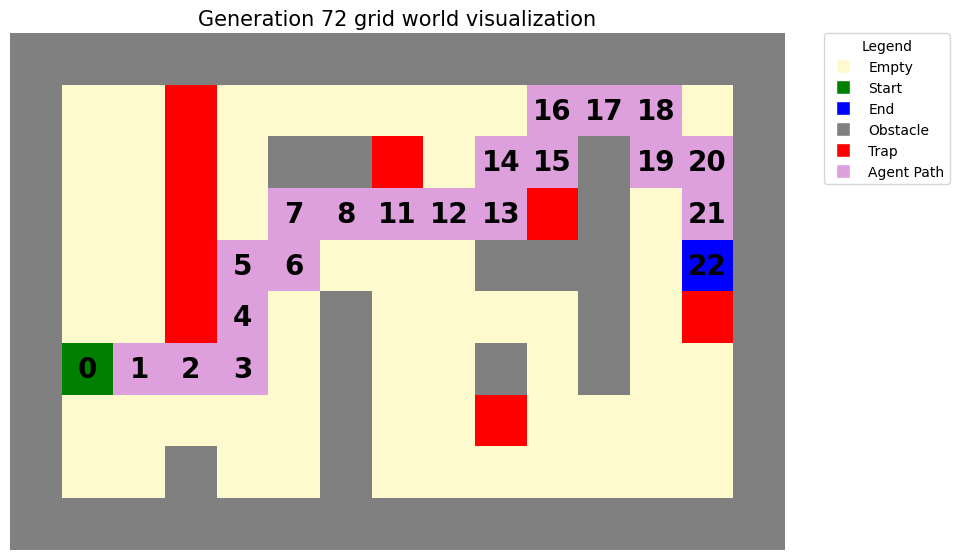

----------------------------------------------------------------------------------------------------

11. generation 80 grid world


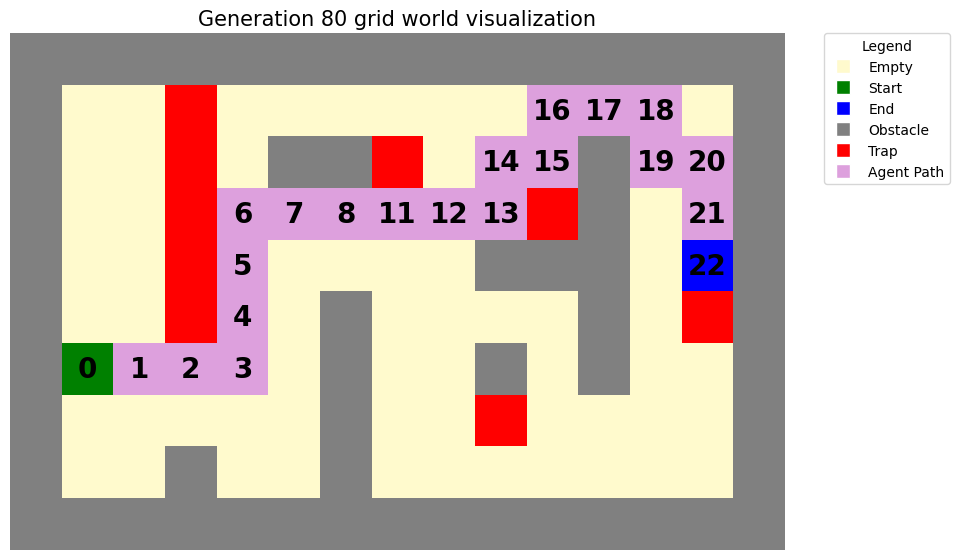

----------------------------------------------------------------------------------------------------

12. generation 84 grid world


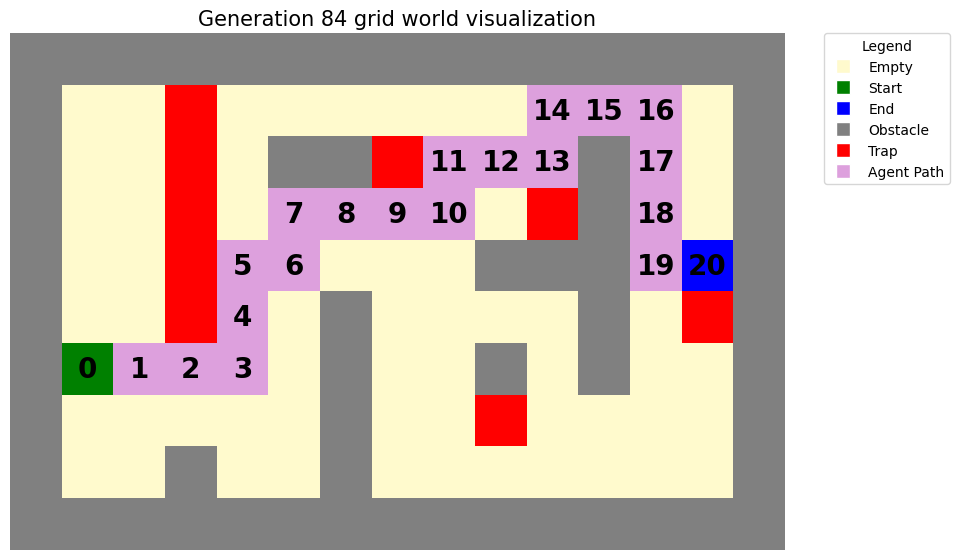

----------------------------------------------------------------------------------------------------



In [14]:
generation_step = generation // 10

counter = 1
for generation, grid_world in enumerate(best_grid_worlds, 1):
    if generation == 1 or generation == best_generation or generation%generation_step == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, agent_path=best_population_paths[generation-1], title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [15]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruction:")
fn.path_reconstruction(
    best_population_paths=best_population_paths, 
    initial_grid_world=initial_grid_world, 
    results_path=ALL_TO_BEST_RESULTS_PATH, 
    start_position=START_POSITION, 
    end_position=END_POSITION, 
    step=generation_step, 
    title_type="generation", 
    path_flag=1
)
print(LINE)
print("Video creation...")
fn.video_creation(ALL_TO_BEST_RESULTS_PATH, ALL_TO_BEST_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

PATHS RECONSTRUCTION AND VIDEO CREATION
Path reconstruction:


Processing generations/iterations: 100%|██████████| 12/12 [02:10<00:00, 10.90s/it]


----------------------------------------------------------------------------------------------------
Video creation...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


Video saved to ./results/GA results/all_to_best_results.mp4
Video creation finished!


frame=  268 fps=161 q=-1.0 Lsize=     362kB time=00:00:53.00 bitrate=  55.9kbits/s speed=31.8x    
video:358kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.940429%
[libx264 @ 0x5613e989e180] frame I:2     Avg QP: 8.35  size: 22470
[libx264 @ 0x5613e989e180] frame P:177   Avg QP:15.74  size:  1579
[libx264 @ 0x5613e989e180] frame B:89    Avg QP:13.90  size:   469
[libx264 @ 0x5613e989e180] consecutive B-frames: 40.7% 38.8% 19.0%  1.5%
[libx264 @ 0x5613e989e180] mb I  I16..4: 81.5%  6.0% 12.5%
[libx264 @ 0x5613e989e180] mb P  I16..4:  1.1%  0.5%  0.7%  P16..4:  1.3%  0.2%  0.1%  0.0%  0.0%    skip:96.2%
[libx264 @ 0x5613e989e180] mb B  I16..4:  0.6%  0.2%  0.2%  B16..8:  1.9%  0.1%  0.0%  direct: 0.3%  skip:96.7%  L0:50.7% L1:48.6% BI: 0.8%
[libx264 @ 0x5613e989e180] 8x8 transform intra:17.4% inter:52.9%
[libx264 @ 0x5613e989e180] coded y,uvDC,uvAC intra: 13.8% 33.7% 28.1% inter: 0.4% 0.7% 0.4%
[libx264 @ 0x5613e989e180] i16 v,h,dc,p: 67% 31%  1%  0%
[li

In [16]:
Video(ALL_TO_BEST_VIDEO_PATH, embed=True)

## Hybrid evolutionary case

In this case, we analyze the convergence behavior of our genetic algorithm, focusing on the segmentation of the population into three groups: the top 20% best-performing individuals, the middle 60% representing the rest of the population, and the bottom 20% initially included but later merged into the rest. The best individuals are preserved and prioritized for reproduction, ensuring that their superior traits are consistently passed on to future generations. This preservation guarantees that the highest-performing solutions are maintained within the population. The middle group provides necessary genetic diversity, promoting exploration and preventing premature convergence. The bottom group is replaced with newly generated individuals to introduce fresh genetic material. This approach balances exploitation of the best solutions, preservation of superior traits, and exploration of new possibilities, driving the population towards optimal solutions over successive generations.

### Simulation

In [17]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

num_best = int(POPULATION_SIZE * BEST_ONES_PERCENTAGE)
num_worst = int(POPULATION_SIZE * WORST_ONES_PERCENTAGE)
num_middle = POPULATION_SIZE - num_best - num_worst

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_paths = []
best_generation = NUM_GENERATIONS
first_full_path_generation = 0
mutation_rate = 0
converge_flag = False

for generation in range(1, NUM_GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(CHROMOSOME_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []

        best_individuals = population_sorted[:num_best]
        middle_individuals = population_sorted[num_best:num_best+num_middle]
        worst_individuals = population_sorted[-num_worst:]

        population.extend(best_individuals)

        for i in range(int(num_middle / 2)):
            agent1 = fn.selection(best_individuals, mode="uniform", random_seed=i)
            agent2 = fn.selection(middle_individuals, mode="uniform", random_seed=i * 42 + 42)

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            if PROGRESSIVE_MUTATION and mutation_rate < 0.1 and fn.check_last_n_generations_same(best_scores, secondary_scores_of_best):
                mutation_rate += MUTATION_RATE
            else:
                mutation_rate = MUTATION_RATE

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=mutation_rate, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=mutation_rate, random_seed=i**2)

            population.extend([mutated_new_agent1, mutated_new_agent2])

        worst_replacements = [fn.generate_agent(CHROMOSOME_LENGTH, random_seed=i + POPULATION_SIZE) for i in range(num_worst)]
        population.extend(worst_replacements)

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_paths = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, path = fn.fitness_score_calculation(
            agent_path=agent, 
            grid_world=initial_grid_world, 
            chromosome_length=CHROMOSOME_LENGTH, 
            start_position=START_POSITION, 
            end_position=END_POSITION, 
            penalty_coefficients=PENALTY_COEFFICIENTS, 
            grid_size=GRID_SIZE
        )
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_score)
        grid_worlds.append(grid_world)
        population_paths.append(path)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_path = population_paths[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_paths.append(best_agent_path)
    best_grid_worlds.append(best_grid_world)

    if generation == 1 or generation % 10 == 0:
        print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
        print(LINE)

    if best_score == 0:
        if not first_full_path_generation:
            first_full_path_generation = generation
    
        if EARLY_STOP or secondary_score_of_best == NUM_OPTIMAL_STEPS:
            converge_flag = True
            best_generation = generation
            print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
            print(LINE)
            break

_, best_indices_sorted = fn.population_sorting(best_population_paths, best_scores, secondary_scores_of_best)
best_generation = best_indices_sorted[0] + 1
final_best_score = best_scores[best_indices_sorted[0]]
final_best_secondary_score = secondary_scores_of_best[best_indices_sorted[0]]

if not converge_flag:
    print("Optimal path is not found!")

print(f"The best generation: {best_generation}")
print(f"The best primary score: {final_best_score}")
print(f"The best secondary score: {final_best_secondary_score}")
print(f"The first full path generation: {first_full_path_generation}")

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. generation finished - best score: 8.8388 - median score: 16.298 - mean score: 15.7787 - steps: 14
----------------------------------------------------------------------------------------------------
 10. generation finished - best score: 3.5355 - median score: 8.8388 - mean score: 11.2239 - steps: 16
----------------------------------------------------------------------------------------------------
 20. generation finished - best score: 1.7678 - median score: 4.7434 - mean score: 7.4673 - steps: 28
----------------------------------------------------------------------------------------------------
 30. generation finished - best score: 0.0 - median score: 3.5355 - mean score: 6.3737 - steps: 22
----------------------------------------------------------------------------------------------------
 40. generation finished - best score: 0.0 - median score: 3.5355 - mean score: 5.3621 - 

### Result scores visualization

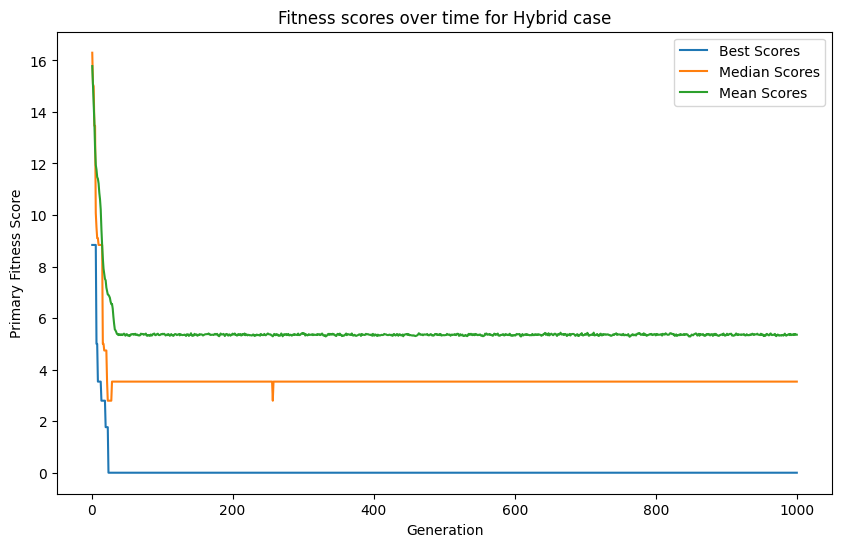

In [18]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for Hybrid case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

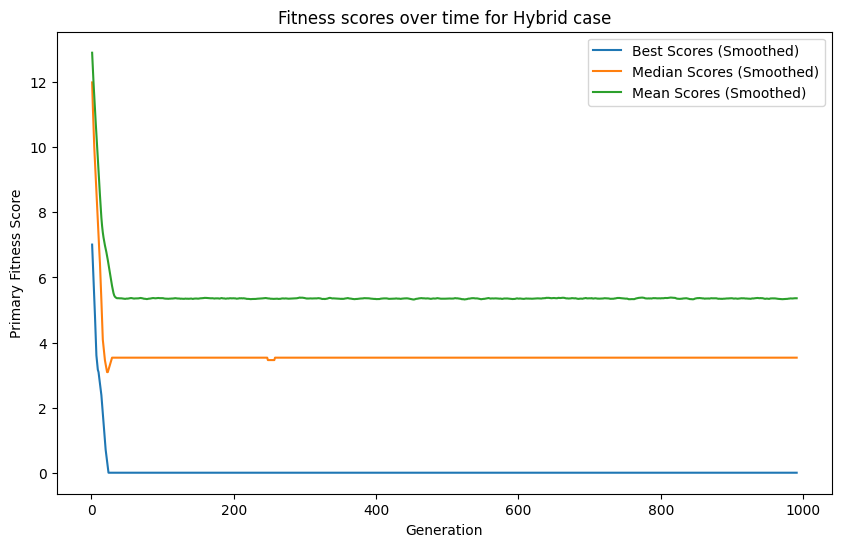

In [19]:
best_scores_smooth = fn.moving_average(best_scores, WINDOW_SIZE)
median_scores_smooth = fn.moving_average(median_scores, WINDOW_SIZE)
mean_scores_smooth = fn.moving_average(mean_scores, WINDOW_SIZE)

x_values_smooth = range(1, len(best_scores_smooth) + 1)

plt.figure(figsize=(10, 6))

plt.plot(x_values_smooth, best_scores_smooth, label="Best Scores (Smoothed)")
plt.plot(x_values_smooth, median_scores_smooth, label="Median Scores (Smoothed)")
plt.plot(x_values_smooth, mean_scores_smooth, label="Mean Scores (Smoothed)")

plt.title("Fitness scores over time for Hybrid case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

### Grid world path optimization evolution

1. generation 1 grid world


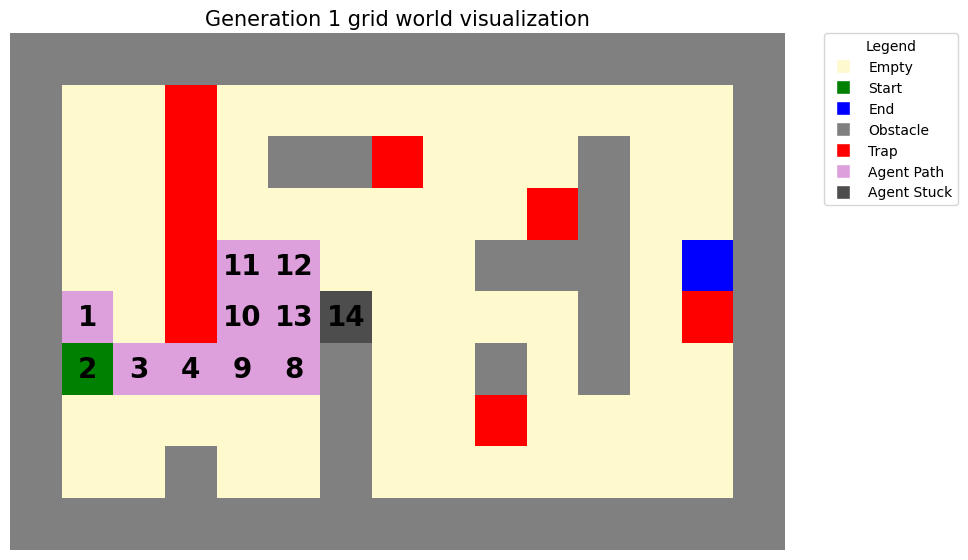

----------------------------------------------------------------------------------------------------

2. generation 28 grid world


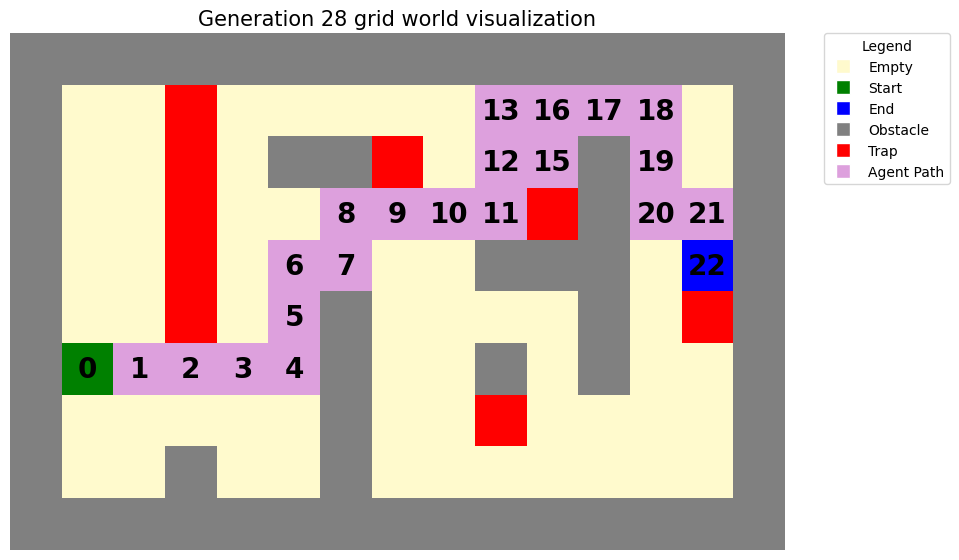

----------------------------------------------------------------------------------------------------

3. generation 100 grid world


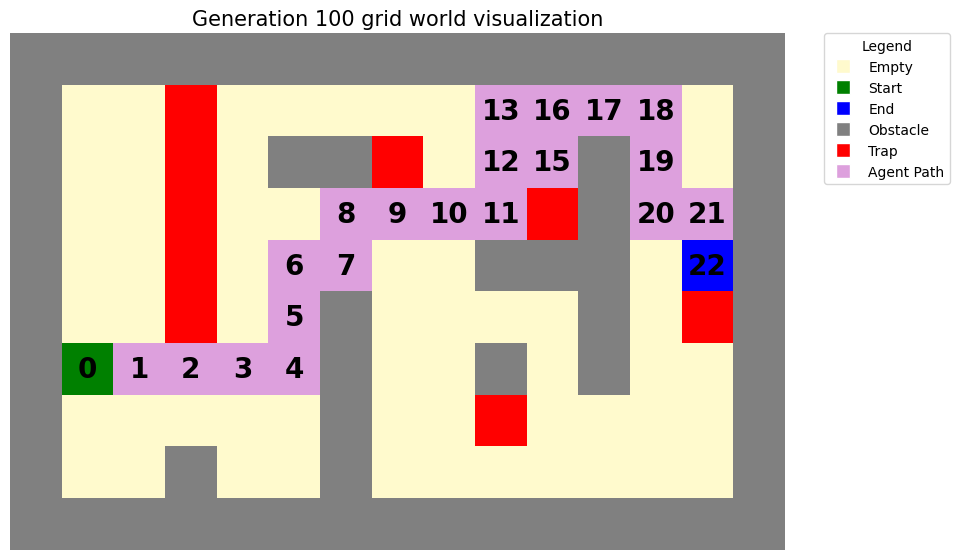

----------------------------------------------------------------------------------------------------

4. generation 200 grid world


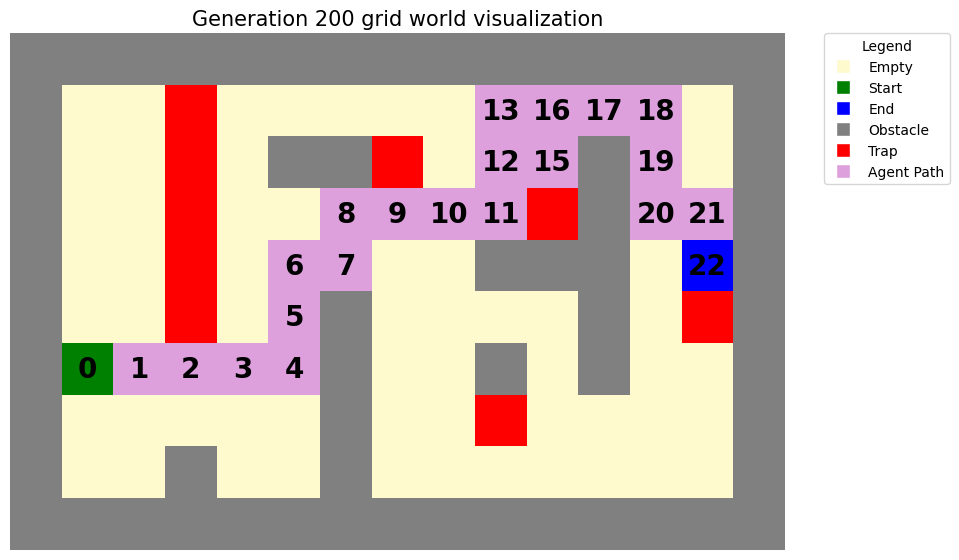

----------------------------------------------------------------------------------------------------

5. generation 300 grid world


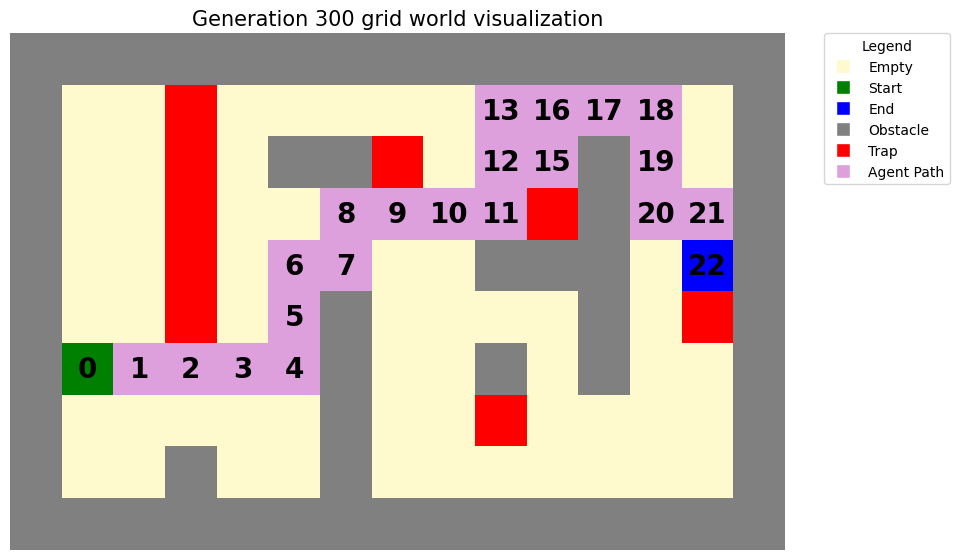

----------------------------------------------------------------------------------------------------

6. generation 400 grid world


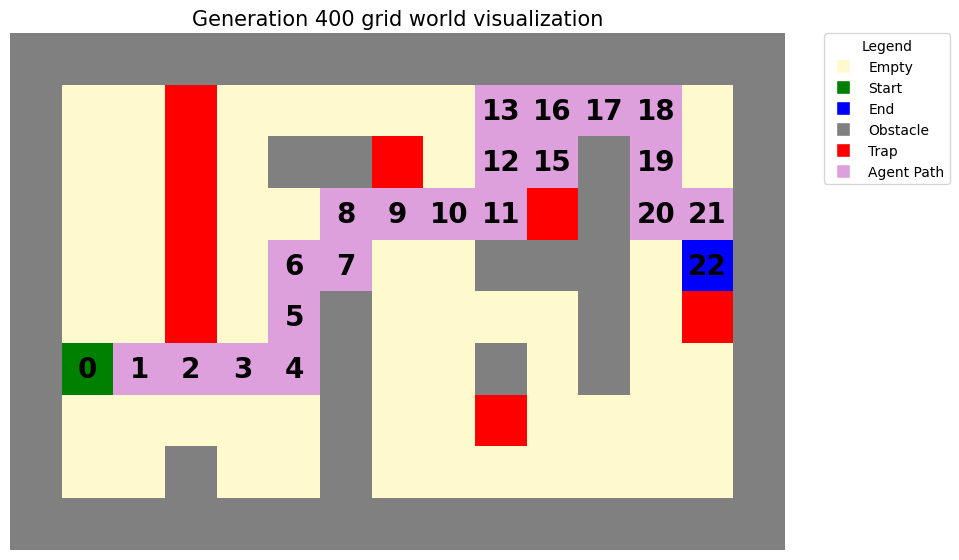

----------------------------------------------------------------------------------------------------

7. generation 500 grid world


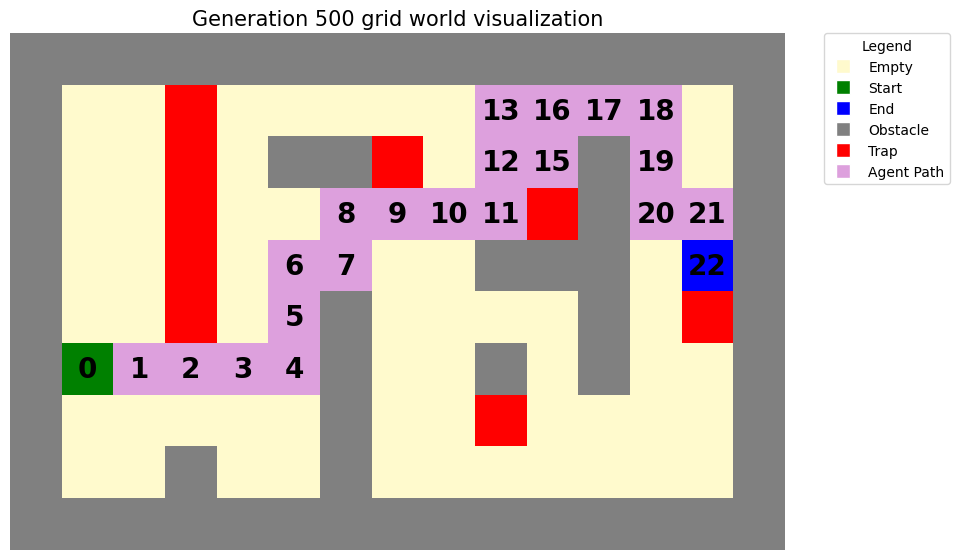

----------------------------------------------------------------------------------------------------

8. generation 600 grid world


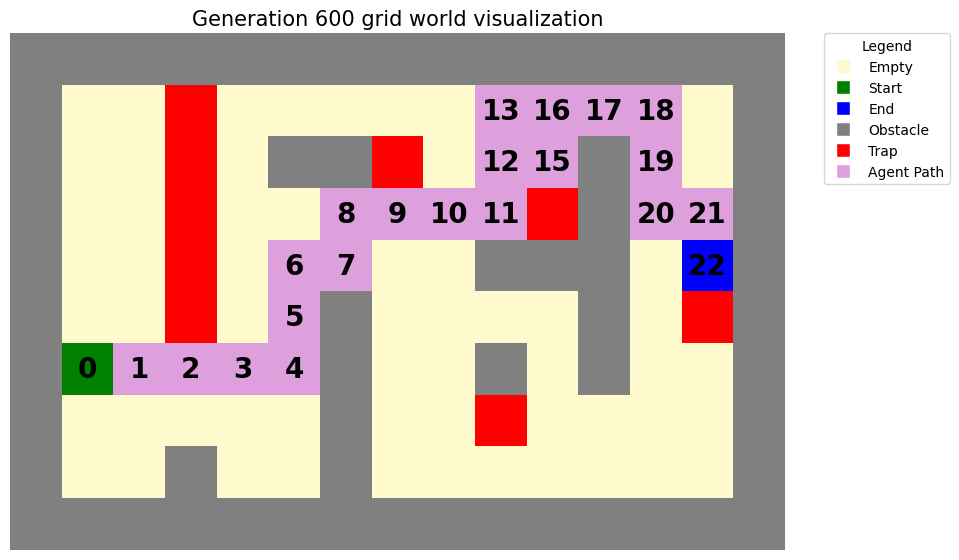

----------------------------------------------------------------------------------------------------

9. generation 700 grid world


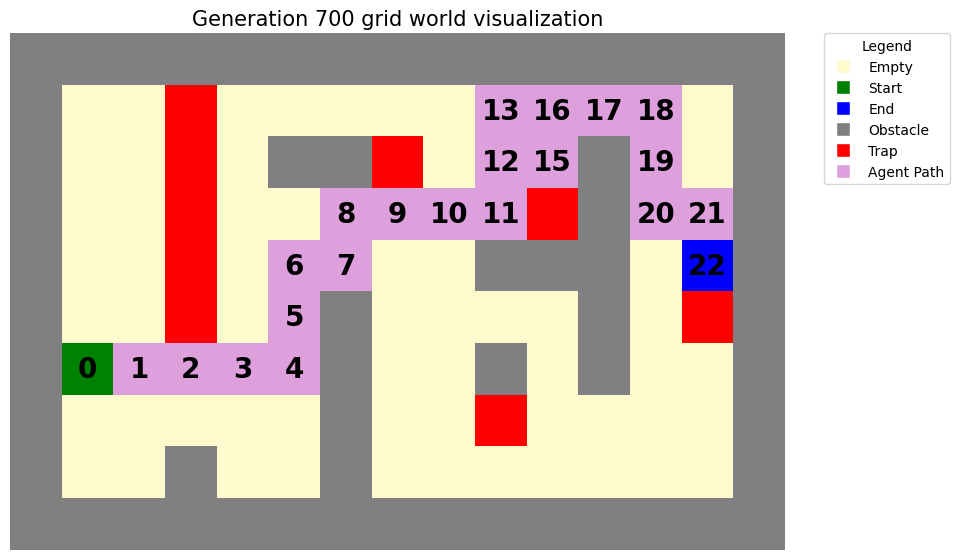

----------------------------------------------------------------------------------------------------

10. generation 800 grid world


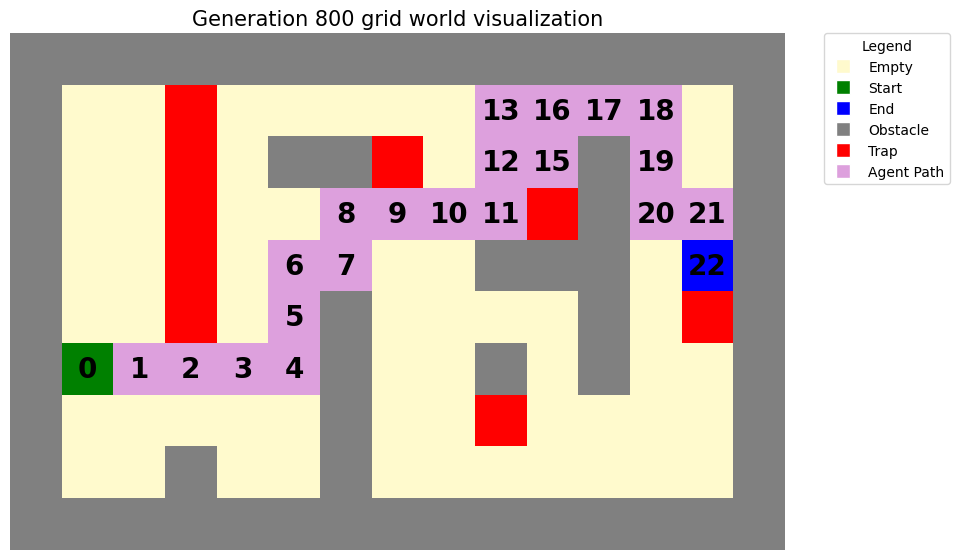

----------------------------------------------------------------------------------------------------

11. generation 900 grid world


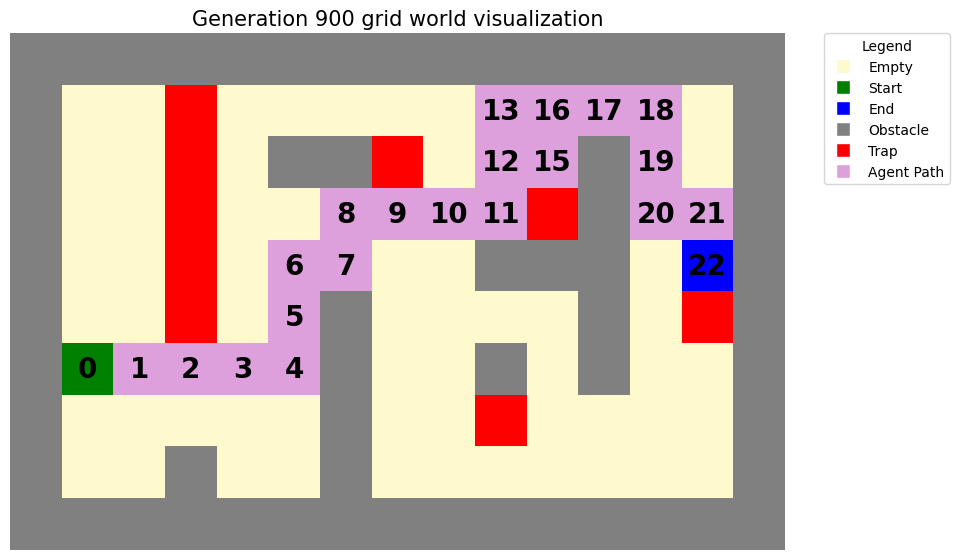

----------------------------------------------------------------------------------------------------

12. generation 1000 grid world


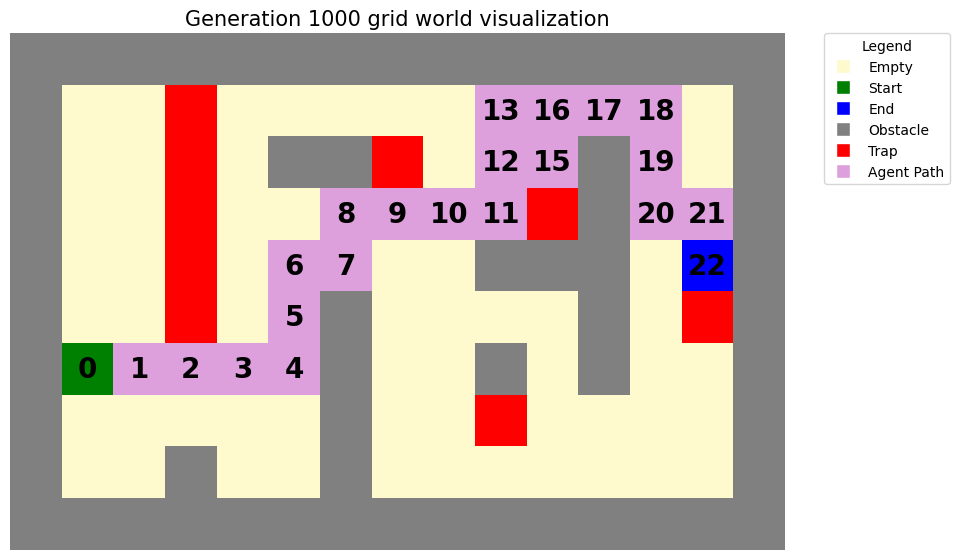

----------------------------------------------------------------------------------------------------



In [20]:
generation_step = generation // 10

counter = 1
for generation, grid_world in enumerate(best_grid_worlds, 1):
    if generation == 1 or generation == best_generation or generation%generation_step == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, agent_path=best_population_paths[generation-1], title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [21]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruction:")
fn.path_reconstruction(
    best_population_paths=best_population_paths, 
    initial_grid_world=initial_grid_world, 
    results_path=HYBRID_RESULTS_PATH, 
    start_position=START_POSITION, 
    end_position=END_POSITION, 
    step=generation_step, 
    title_type="generation", 
    path_flag=1
)
print(LINE)
print("Video creation...")
fn.video_creation(HYBRID_RESULTS_PATH, HYBRID_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

PATHS RECONSTRUCTION AND VIDEO CREATION
Path reconstruction:


Processing generations/iterations: 100%|██████████| 11/11 [02:02<00:00, 11.18s/it]


----------------------------------------------------------------------------------------------------
Video creation...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


Video saved to ./results/GA results/hybrid_results.mp4
Video creation finished!


frame=  245 fps=155 q=-1.0 Lsize=     328kB time=00:00:48.40 bitrate=  55.4kbits/s speed=30.5x    
video:324kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.002816%
[libx264 @ 0x560d174e0bc0] frame I:1     Avg QP: 9.95  size: 19857
[libx264 @ 0x560d174e0bc0] frame P:170   Avg QP:16.07  size:  1647
[libx264 @ 0x560d174e0bc0] frame B:74    Avg QP:13.33  size:   425
[libx264 @ 0x560d174e0bc0] consecutive B-frames: 44.5% 40.8% 14.7%  0.0%
[libx264 @ 0x560d174e0bc0] mb I  I16..4: 80.1%  9.1% 10.7%
[libx264 @ 0x560d174e0bc0] mb P  I16..4:  1.2%  0.5%  0.6%  P16..4:  1.2%  0.2%  0.1%  0.0%  0.0%    skip:96.2%
[libx264 @ 0x560d174e0bc0] mb B  I16..4:  0.7%  0.2%  0.2%  B16..8:  2.0%  0.2%  0.0%  direct: 0.3%  skip:96.5%  L0:53.6% L1:46.0% BI: 0.5%
[libx264 @ 0x560d174e0bc0] 8x8 transform intra:19.2% inter:55.7%
[libx264 @ 0x560d174e0bc0] coded y,uvDC,uvAC intra: 13.3% 35.4% 28.2% inter: 0.4% 0.8% 0.5%
[libx264 @ 0x560d174e0bc0] i16 v,h,dc,p: 63% 35%  2%  0%
[li

In [22]:
Video(HYBRID_VIDEO_PATH, embed=True)